In [82]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# extract activation map for ISIC 2017 validation set

# compute culprit score from the activations, predictions, and gt

In [ ]:
from culprit import *
import json
config = json.load(open('config_skin_alexnet.json'))
os.environ["CUDA_VISIBLE_DEVICES"]= '1'
resume = 'skinmodel/checkpoint.pth'

In [57]:
from uncertainty import *

In [58]:
experiment_saved_path = './saved'
uncty = Uncertainty(experiment_saved_path)

*** actv shape (ignore dim 0 - batch size) is: [torch.Size([64, 64, 55, 55]), torch.Size([64, 192, 27, 27]), torch.Size([64, 384, 13, 13]), torch.Size([64, 256, 13, 13]), torch.Size([64, 256, 13, 13]), torch.Size([64, 4096]), torch.Size([64, 4096]), torch.Size([64, 2])] .
*** data loaded ***
*** Flattened actv vector shape is torch.Size([150, 9346]).
*** actv shape (ignore dim 0 - batch size) is: [torch.Size([64, 64, 55, 55]), torch.Size([64, 192, 27, 27]), torch.Size([64, 384, 13, 13]), torch.Size([64, 256, 13, 13]), torch.Size([64, 256, 13, 13]), torch.Size([64, 4096]), torch.Size([64, 4096]), torch.Size([64, 2])] .
*** data loaded ***
*** label size is torch.Size([600]), right prediction is 459.
*** feature shape is torch.Size([600, 9346]).
*** right_actv shape is torch.Size([459, 9346]), wrong_actv shape is torch.Size([141, 9346]).


In [59]:
uncty.error.shape

(150, 2)

In [62]:
select = uncty.clpt.culprit_selectivity(0)

385 -1.8575823 1.0


In [71]:
uncty.clpt.get_feature()

*** feature shape is torch.Size([600, 9346]).
*** right_actv shape is torch.Size([459, 9346]), wrong_actv shape is torch.Size([141, 9346]).


In [77]:
np.isnan(uncty.query_actv).sum()

tensor(0)

In [73]:
clpt_mtx = uncty.get_culprit_matrix('select')

*** select method, culprit matrix shape is: (2, 9346)


In [80]:
sim_method = 'cosine'
uncty_mtx = uncty.get_uncertain_matrix(clpt_mtx, uncty.query_actv, sim_method)     

In [81]:
uncty_mtx.shape

(150, 2)

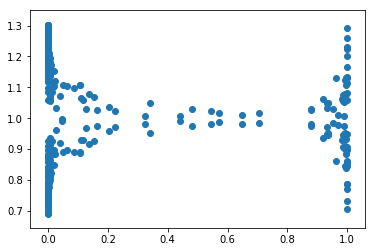

In [83]:
plt.scatter(uncty.error.reshape(-1), uncty_mtx.reshape(-1))

In [108]:
from scipy.stats import pearsonr
corr = pearsonr(uncty.error.reshape(-1), uncty_mtx.reshape(-1))
corr

(-0.0025307703761546342, 0.9651823553603253)

In [107]:
corr0 = pearsonr(uncty.error[:,0], uncty_mtx[:,0])
corr0

(-0.49455064252723685, 1.2568084809230247e-10)

Text(0.5,1,'image class = 0')

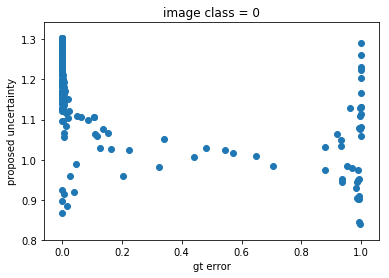

In [109]:
plt.scatter(uncty.error[:,0], uncty_mtx[:,0])
plt.xlabel('gt error')
plt.ylabel('proposed uncertainty')
plt.title('image class = 0')

In [112]:
corr1 = pearsonr(uncty.error[:,1], uncty_mtx[:,1])
corr1

(0.4987844248410928, 8.247692644680902e-11)

Text(0.5,1,'image class = 1')

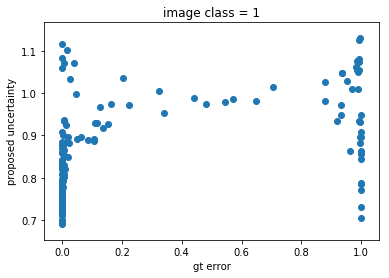

In [111]:
plt.scatter(uncty.error[:,1], uncty_mtx[:,1])
plt.xlabel('gt error')
plt.ylabel('proposed uncertainty')
plt.title('image class = 1')

Text(0.5,1,'the gt error and the proposed uncertainty for the query 150 images')

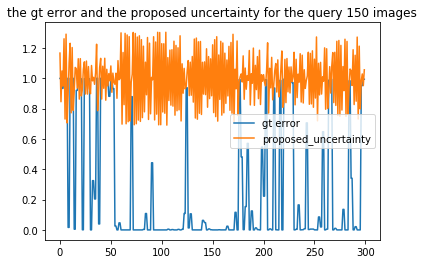

In [113]:
plt.plot(uncty.error.reshape(-1))
plt.plot(uncty_mtx.reshape(-1))
plt.legend(['gt error', 'proposed_uncertainty'])
plt.title('the gt error and the proposed uncertainty for the query 150 images')

Text(0.5,1,'the gt error and the proposed uncertainty for the query 150 images, when class = 1')

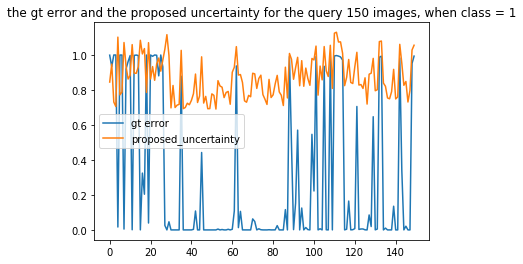

In [115]:
plt.plot(uncty.error[:,1])
plt.plot(uncty_mtx[:,1])
plt.legend(['gt error', 'proposed_uncertainty'])
plt.title('the gt error and the proposed uncertainty for the query 150 images, when class = 1')

Text(0.5,1,'the gt error and the proposed uncertainty for the query 150 images, when class = 0')

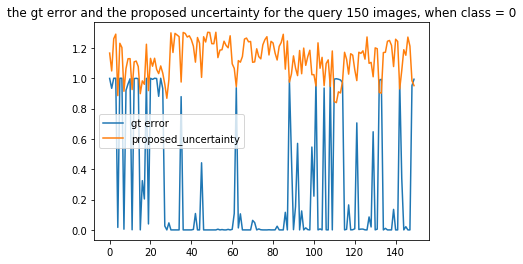

In [116]:
plt.plot(uncty.error[:,0])
plt.plot(uncty_mtx[:,0])
plt.legend(['gt error', 'proposed_uncertainty'])
plt.title('the gt error and the proposed uncertainty for the query 150 images, when class = 0')

In [120]:
bsl_clpt = uncty.get_baseline(clpt_mtx)

In [121]:
bsl_uncty_mtx = uncty.get_uncertain_matrix(bsl_clpt, uncty.query_actv, sim_method)     

In [125]:
bsl_corr0 = pearsonr(uncty.error[:,0], bsl_uncty_mtx[:,0])
bsl_corr0

(0.18256162001377804, 0.02534943685791861)

Text(0.5,1,'baseline random culprit mtx: image class = 0')

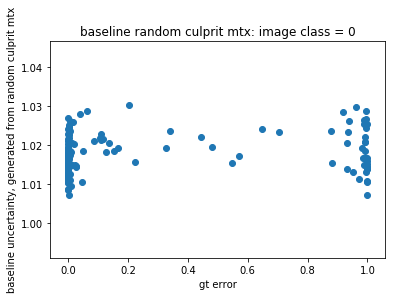

In [129]:
plt.scatter(uncty.error[:,0], bsl_uncty_mtx[:,0])
plt.xlabel('gt error')
plt.ylabel('baseline uncertainty, generated from random culprit mtx')
plt.title('baseline random culprit mtx: image class = 0')

In [127]:
bsl_corr1 = pearsonr(uncty.error[:,1], bsl_uncty_mtx[:,1])
bsl_corr1

(-0.4411453441420548, 1.6022367563218343e-08)

Text(0.5,1,'baseline random culprit mtx: image class = 1')

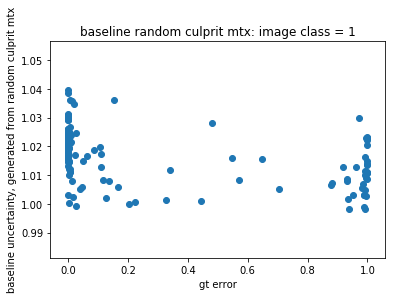

In [130]:
plt.scatter(uncty.error[:,1], bsl_uncty_mtx[:,1])
plt.xlabel('gt error')
plt.ylabel('baseline uncertainty, generated from random culprit mtx')
plt.title('baseline random culprit mtx: image class = 1')

Text(0.5,1,'the gt error and the baseline uncertainty for the query 150 images, when class = 0')

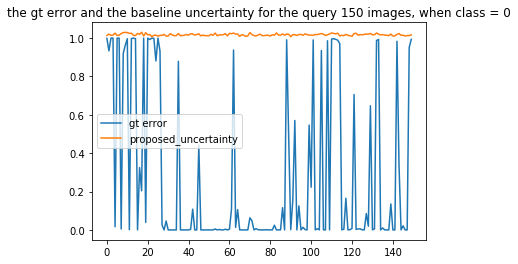

In [132]:
plt.plot(uncty.error[:,0])
plt.plot(bsl_uncty_mtx[:,0])
plt.legend(['gt error', 'proposed_uncertainty'])
plt.title('the gt error and the baseline uncertainty for the query 150 images, when class = 0')

Text(0.5,1,'the gt error and the baseline uncertainty for the query 150 images, when class = 1')

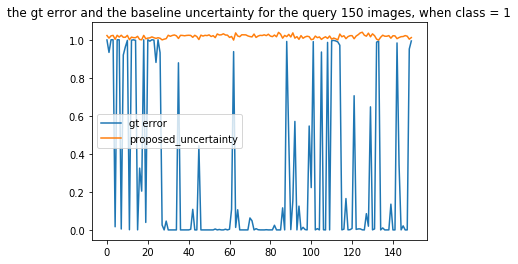

In [133]:
plt.plot(uncty.error[:,1])
plt.plot(bsl_uncty_mtx[:,1])
plt.legend(['gt error', 'proposed_uncertainty'])
plt.title('the gt error and the baseline uncertainty for the query 150 images, when class = 1')

# for visualizaiton prototype

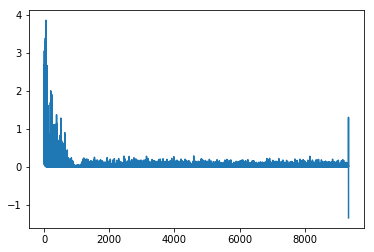

In [152]:
datapoint = 1
inspect_cls = 1
plt.plot(uncty.query_actv[datapoint].numpy())

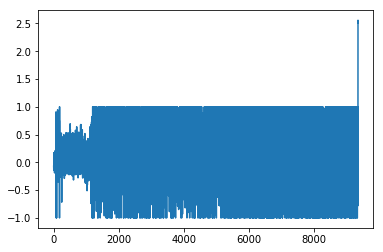

In [154]:
plt.plot(np.arange(0, len(clpt_mtx[inspect_cls])), clpt_mtx[inspect_cls])